In [383]:
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
import threading
import time
import concurrent.futures
%matplotlib inline

# Predict Median House Val for California Housing Dataset

## Get Dataset

In [384]:
cal_housing = datasets.fetch_california_housing(as_frame=True)
cal_housing.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])

## Dataset Description

In [385]:
print(cal_housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

## Make a copy of the DataFrame

In [386]:
cal_housing_df = cal_housing.frame.copy()
cal_housing_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [387]:
cal_housing_df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


## Remove outliers: 10Plus AveRooms

In [388]:
houses_with_10_plus_rooms = cal_housing_df[cal_housing_df.AveRooms > 10 ]

In [389]:
houses_with_10_plus_rooms.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000
mean,4.175384,18.203540,19.329241,3.852075,590.685841,2.609121,36.760531,-119.072345,1.865744
std,2.505434,9.802185,15.117295,3.375181,613.668867,1.054432,2.433460,2.008064,1.176683
min,0.499900,1.000000,10.005874,1.092664,9.000000,0.692308,32.680000,-123.490000,0.149990
25%,2.739550,12.000000,11.214255,2.180435,189.500000,2.182121,34.240000,-120.267500,1.148500
50%,3.614600,17.000000,14.723584,2.866894,384.000000,2.486068,37.505000,-119.605000,1.494500
75%,4.811575,23.000000,21.573043,4.525007,780.000000,2.750631,39.055000,-117.162500,2.186750
max,15.000100,52.000000,141.909091,34.066667,4176.000000,14.000000,41.500000,-114.310000,5.000010


In [390]:
cal_housing_df.drop(houses_with_60_plus_rooms.index, inplace=True)

## Data analysis

In [391]:
cal_housing_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20414 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20414 non-null  float64
 1   HouseAge     20414 non-null  float64
 2   AveRooms     20414 non-null  float64
 3   AveBedrms    20414 non-null  float64
 4   Population   20414 non-null  float64
 5   AveOccup     20414 non-null  float64
 6   Latitude     20414 non-null  float64
 7   Longitude    20414 non-null  float64
 8   MedHouseVal  20414 non-null  float64
dtypes: float64(9)
memory usage: 1.6 MB


In [392]:
cal_housing_df.isna().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

## Check the basic statistics

In [393]:
cal_housing_df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20414.000000,20414.000000,20414.000000,20414.000000,20414.000000,20414.000000,20414.000000,20414.000000,20414.000000
mean,3.867298,28.755021,5.275112,1.066171,1434.718575,3.075765,35.619366,-119.575211,2.070803
std,1.891839,12.564702,1.227792,0.128552,1133.453777,10.442684,2.129148,2.002840,1.153532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.750000,32.540000,-124.350000,0.149990
25%,2.562500,18.000000,4.432186,1.005525,795.000000,2.433932,33.930000,-121.800000,1.198000
50%,3.534100,29.000000,5.213242,1.047851,1173.000000,2.824303,34.250000,-118.490000,1.804000
75%,4.742600,37.000000,6.016048,1.097294,1731.000000,3.286480,37.710000,-118.010000,2.652000
max,15.000100,52.000000,10.000000,3.411111,35682.000000,1243.333333,41.950000,-114.550000,5.000010


## Check corellation

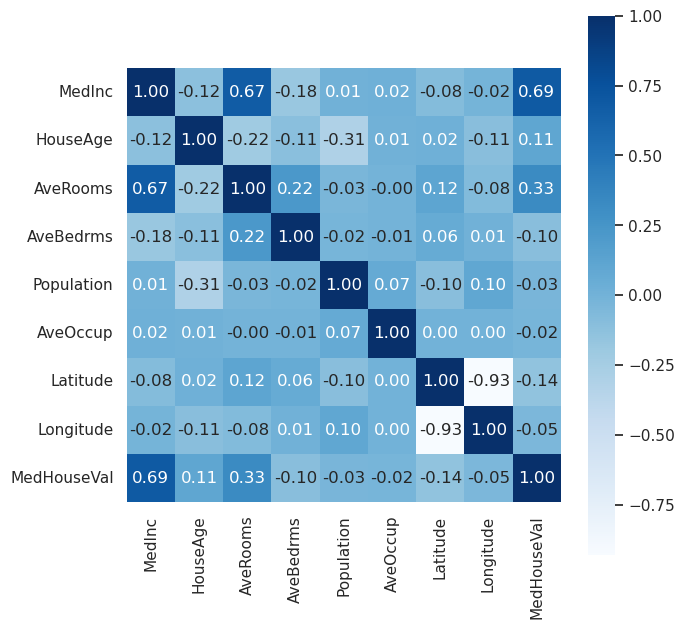

In [394]:
sns.set_theme()
plt.figure(figsize=(7,7))
dataplot = sns.heatmap(cal_housing_df.corr(), cmap="Blues", annot=True, fmt='.2f', square=True)
plt.show()

## Check distribution of target MedVal

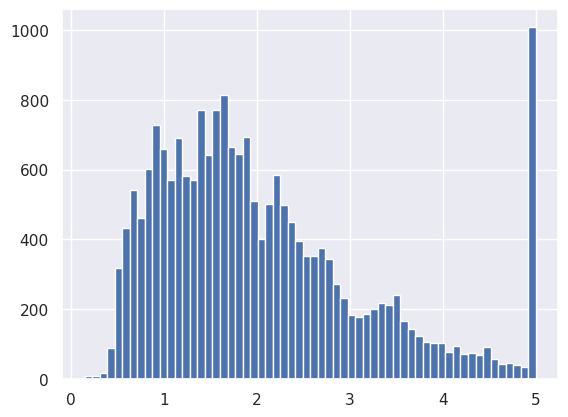

In [395]:
cal_housing_df.MedHouseVal.hist(bins=60);

## Normalizing the target variable

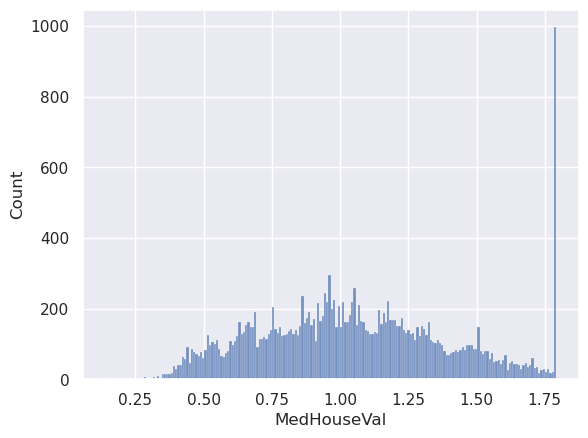

In [396]:
sns.histplot(np.log1p(cal_housing_df.MedHouseVal), bins=200);

## Randomize

In [397]:
# randomize dataset to avoid bias
idx = np.arange(cal_housing_df.shape[0]) #create list of 0 - n-1

np.random.seed(20) # to always get same randomness
np.random.shuffle(idx) # shuffle list


cal_housing_df = cal_housing_df.iloc[idx]
cal_housing_df.reset_index(drop=True, inplace=True)

In [398]:
cal_housing_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,3.0469,20.0,5.656000,1.008000,337.0,2.696000,39.74,-122.16,0.85000
1,4.5625,33.0,5.867621,1.017889,1583.0,2.831843,37.27,-121.92,2.53500
2,4.9022,35.0,5.482332,0.948763,1614.0,2.851590,37.99,-122.03,1.69300
3,7.9614,43.0,5.702517,1.027460,1033.0,2.363844,33.88,-118.41,5.00001
4,4.1652,4.0,4.032500,1.047500,1666.0,2.082500,33.68,-117.83,1.84500


## Normalize target variable

In [399]:
cal_housing_df["MedHouseVal"] = np.log1p(cal_housing_df.MedHouseVal)

In [400]:
cal_housing_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,3.0469,20.0,5.656000,1.008000,337.0,2.696000,39.74,-122.16,0.615186
1,4.5625,33.0,5.867621,1.017889,1583.0,2.831843,37.27,-121.92,1.262713
2,4.9022,35.0,5.482332,0.948763,1614.0,2.851590,37.99,-122.03,0.990656
3,7.9614,43.0,5.702517,1.027460,1033.0,2.363844,33.88,-118.41,1.791761
4,4.1652,4.0,4.032500,1.047500,1666.0,2.082500,33.68,-117.83,1.045563


## Splitting Dataset

In [401]:
def spilt_dataset(data_df: pd.DataFrame, features: list, target: str):
    #data sizes
    test_size = int(data_df.shape[0] * 0.2)
    val_size = int(data_df.shape[0] * 0.2)
    train_size = data_df.shape[0] - test_size - val_size

    # test_data
    test_data = data_df[:test_size]
    X_test = test_data[features].values
    y_test = test_data[target].values

    #val_data
    val_data = data_df[test_size:test_size+train_size]
    X_val = val_data[features].values
    y_val = val_data[target].values

    #training_data
    train_data = data_df[test_size+train_size:] 
    X_train = train_data[features].values
    y_train = train_data[target].values

    return X_train, y_train, X_val, y_val, X_test, y_test
    

In [402]:
features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']
target = ['MedHouseVal']

In [403]:
X_train, y_train, X_val, y_val, X_test, y_test = spilt_dataset(cal_housing_df, features, target)

In [404]:
print(cal_housing_df.shape, (X_test.shape[0] + X_val.shape[0] + X_train.shape[0]))

(20414, 9) 20414


## Train the model

In [405]:
def train_linear_reg(X, y, r=0.1):
    ones = np.ones(X.shape[0])
    X = np.column_stack((ones, X))
    XTX = X.T.dot(X)
    
    XTX = XTX + r * np.eye(XTX.shape[0])
    
    XTX_inv = np.linalg.inv(XTX)
    weights = XTX_inv.dot(X.T).dot(y)

    return weights[0], weights[1:]

def rmse(y, y_pred):
    se = (y-y_pred) ** 2
    return np.sqrt(se.mean())

In [406]:
def find_best_r():
    reg = np.linspace(0,1,50, endpoint=False)
    for r in reg:
        w0, w = train_linear_reg(X_train, y_train, r=r)
        y_pred = w0 + X_val.dot(w)
        print(r)
        print(rmse(y_val, y_pred))
        print("-"*50)

In [407]:
w0, w = train_linear_reg(X_train, y_train, r=0)
w0, w

(array([0.4171269]),
 array([[ 1.74853232e-01],
        [ 4.17676589e-03],
        [-9.63846096e-02],
        [ 3.26818356e-01],
        [ 6.15335111e-06],
        [ 2.28478893e-04]]))

## Using train data with model

0.24590155725466614


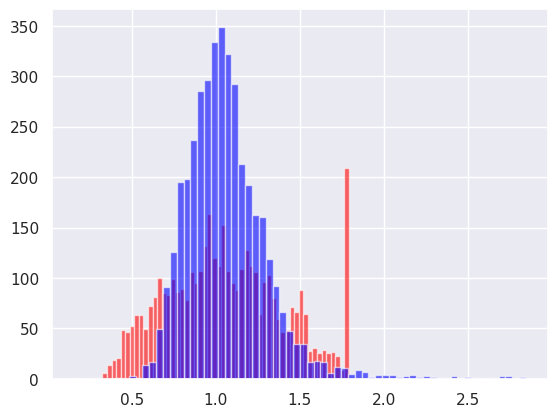

In [408]:
y_pred = w0 + X_train.dot(w)

plt.hist(y_train, bins=60, color='red', alpha=0.6)
plt.hist(y_pred, bins=60, color='blue', alpha=0.6)
print(rmse(y_train, y_pred))
plt.show()

## Use validation data with model

0.24339281146758737


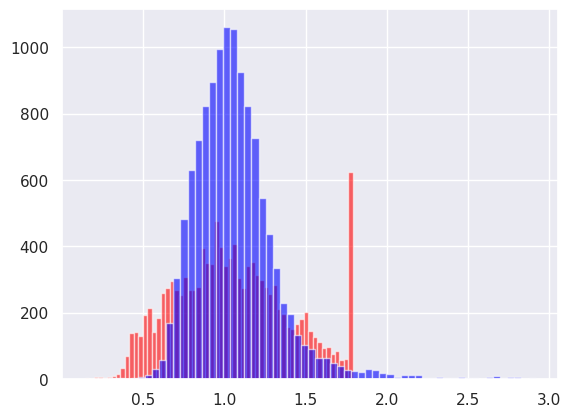

In [409]:
## thre outliers to be dealth with
y_pred = w0 + X_val.dot(w)
plt.hist(y_val, bins=60, color='red', alpha=0.6)
plt.hist(y_pred, bins=60, color='blue', alpha=0.6)
print(rmse(y_val, y_pred))
plt.show()

## Retraining model with Train and Val

In [410]:
X_full_train = np.concatenate([X_train, X_val])
y_full_train = np.concatenate([y_train, y_val])

In [411]:
w0_full, w_full = train_linear_reg(X_full_train, y_full_train, r=0)
w0_full, w_full

(array([0.31085494]),
 array([[ 1.77616344e-01],
        [ 4.46591235e-03],
        [-9.47707513e-02],
        [ 3.93724740e-01],
        [ 1.10381284e-05],
        [-1.43346767e-03]]))

0.24117395074200745


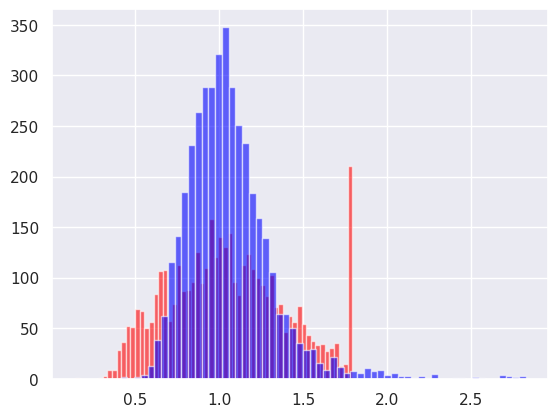

In [412]:
y_pred = w0_full+X_test.dot(w_full)
rmse(y_test, y_pred)

plt.hist(y_test, bins=60, color='red', alpha=0.6)
plt.hist(y_pred, bins=60, color='blue', alpha=0.6)
print(rmse(y_test, y_pred))
plt.show()

## Misc -> download location info

In [413]:
cal_housing_df['lat_long'] = cal_housing_df['Latitude'].astype(str) + ',' + cal_housing_df['Longitude'].astype(str)

def get_city(cal_housing_df):
    latlong_address = []
    
    lat_long = cal_housing_df['lat_long'].values
    unique_lat_long = list(set(lat_long))
    
    geolocator = Nominatim(user_agent="alabamustapha@gmail.com")
    
    for lat_long in unique_lat_long:
        print("Trying to get: {}".format(lat_long))
        try:
            location = geolocator.reverse(value)
            
            lat_long_details =  {
                "lat_long": value,
                "house_number": location.raw["address"].get('house_number', ''), 
                "road": location.raw["address"].get('road', ''),
                "hamlet": location.raw["address"].get('hamlet', ''),
                "town": location.raw["address"].get('town', ''),
                "county": location.raw["address"].get('county', ''),
                "postcode": location.raw["address"].get('postcode', ''),
            }
    
            latlong_address.append(lat_long_details)
            print(lat_long_details)
        except:

            print("Couldn't pull {}".format(lat_long))

        print(len(latlong_address))
        time.sleep(3)

    latlong_address = get_city(cal_housing_df)
    latlong_address_df = pd.DataFrame(latlong_address)
    latlong_address_df.to_csv("latlong_address.csv", index=False)

    return latlong_address

